# MNIST VAE experiments
This notebook evaluates linear and convolutional Variational Autoencoders implemented in `vae.py`.  
We evaluate multiple loss functions and shape to validate the reconstruction.

In [1]:
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader  
import torch
import neptune
import plotly.express as px
from sklearn.manifold import TSNE

from models.vae_model.model_config import LinearVAEConfig, CNNVAEConfig
from models.model_class import Model
from models.loss_functions.loss_functions import MSELossFunction, VAELossFunction

In [2]:
%load_ext autoreload
%autoreload 2

## Helperfunctions

In [3]:
class Scale:
    def __init__(self, size=(140, 140)):
        self.size = size

    def __call__(self, image):
        return transforms.functional.resize(image, self.size)

## MNIST experiments

In [4]:
EPOCHS = 20
BATCH_SIZE = 32

INPUT_DIM = 76
Z_DIM = 200
H_DIM = 64

### CNN VAE

In [5]:
mnist_dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.Compose([
    transforms.ToTensor(),
    Scale(size=(INPUT_DIM, INPUT_DIM))
]), download=True)

train_loader = DataLoader(dataset=mnist_dataset, batch_size=BATCH_SIZE, shuffle=True)

mnist_test_dataset = datasets.MNIST(root="dataset/", train=False, transform=transforms.Compose([
    transforms.ToTensor(),
    Scale(size=(INPUT_DIM, INPUT_DIM))
]), download=True)

test_loader = DataLoader(dataset=mnist_test_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_data_iterator = iter(test_loader)

In [8]:
neptune_run = neptune.init_run(
    project="lmoser/TestSetup",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlZjNhZDEwNy1kOWQzLTQ3YWEtYWIwYi1jYzBiMmMxYTdmMzcifQ==",
)

/tmp/ipykernel_68810/3670397253.py:1: NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/
  neptune_run = neptune.init_run(


https://app.neptune.ai/lmoser/TestSetup/e/TES-10


In [6]:
neptune_run = None

In [7]:
cnn_config = {
    "model_config": {
        "hidden_dims": [1, 2, 4, 8, 16], # Channels of hidden layers
        "z_dim": Z_DIM,
        "input_shape": [1, INPUT_DIM, INPUT_DIM],
        "relu_slope": 0.005,
        "batch_norm": True
    },
    "hyperparameters": {
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "learning_rate": 0.005,
        "loss_function": MSELossFunction
    }
}

config_object = CNNVAEConfig(**cnn_config)
vae_cnn = Model(config_object, neptune_run=neptune_run)

vae_cnn.test_shape(test_loader)

Shape of input x: torch.Size([32, 1, 76, 76])
Shape of encoded x: torch.Size([32, 144])
Shape of latent vector z: torch.Size([32, 200])
Shape of reconstructed x: torch.Size([32, 1, 76, 76])
Length of flattend decoder output: 144
Shape of reconstructed x (before trimming): torch.Size([32, 1, 78, 78])


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [8]:
vae_cnn.train(train_loader, test_loader)

Epoch: 5, validation loss: 0.0025
Epoch: 10, validation loss: 0.0022
Epoch: 15, validation loss: 0.0021
Epoch: 20, validation loss: 0.0019
Best validation loss: 0.0019 in epoch: 20


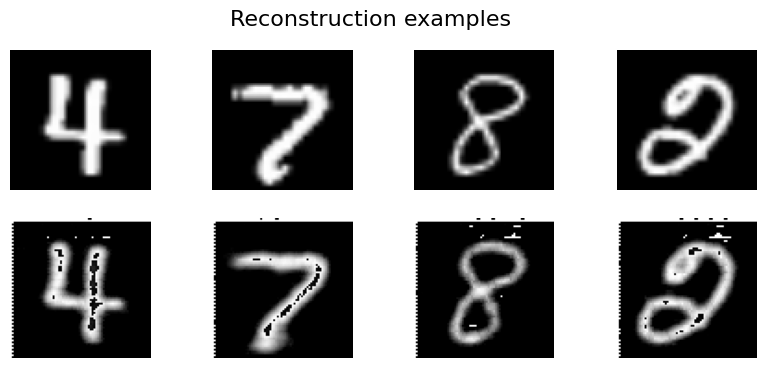

In [9]:
fig = vae_cnn.plot_model_reconstruction(test_loader, lambda x : torch.squeeze(x))

In [ ]:
neptune_run.stop()

### VAE embeddings
Compute the VAE embeddings for the test set and run t-SNE clustering on the embedding.

In [140]:
embeddings = []
labels = []
for _, features in enumerate(test_loader):
    x = features[0].to(vae_cnn.device)
    labels.extend(features[1].cpu().detach().numpy())

    x_encoded = vae_cnn.vae_model.encoder(x)

    z_mean, z_sigma = vae_cnn.vae_model.z_mean(x_encoded), vae_cnn.vae_model.z_sigma(x_encoded)
    z_vec = vae_cnn.vae_model.construct_z(z_mean, z_sigma)
    z_np = z_vec.cpu().detach().numpy()
    embeddings.extend(list(z_np))

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', n_iter=2000, perplexity=40).fit_transform(np.array(embeddings))

In [142]:
string_labels = [str(label) for label in labels]
fig = px.scatter(x=X_embedded[:, 0], y=X_embedded[:, 1], color=string_labels, title="VAE MNIST embeddings - clustering")

fig.update_layout(width=500, height=500)
fig.update_xaxes(showline=False, showgrid=False, zeroline=False, showticklabels=False, title_text='')
fig.update_yaxes(showline=False, showgrid=False, zeroline=False, showticklabels=False, title_text='')
fig.update_layout(legend_title="Clusters")
fig.update_layout(
    title=dict(x=0.5),
    margin=dict(l=20, r=20, t=40, b=20)
)

fig.show()

## Linear VAE

In [ ]:
mnist_dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.Compose([
    transforms.ToTensor(),
    torch.flatten
]), download=True)

train_loader = DataLoader(dataset=mnist_dataset, batch_size=BATCH_SIZE, shuffle=True)

mnist_test_dataset = datasets.MNIST(root="dataset/", train=False, transform=transforms.Compose([
    transforms.ToTensor(),
    torch.flatten
]), download=True)

test_loader = DataLoader(dataset=mnist_test_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_data_iterator = iter(test_loader)

In [ ]:
linear_config = {
    "model_config": {
        "hidden_dims": [300, 100], # Dimmension of hidden layers
        "z_dim": 20,
        "input_dim": 28*28,
        "relu_slope": 0.005,
        "batch_norm": True
    },
    "hyperparameters": {
        "epochs": 20,
        "batch_size": 32,
        "learning_rate": 0.005,
        "loss_function": MSELossFunction
    }
}
config_object = LinearVAEConfig(**linear_config)
vae_linear = Model(config_object, cuda_device_num=3)

vae_linear.test_shape(train_loader)

Shape of input x: torch.Size([32, 784])
Shape of encoded x: torch.Size([32, 100])
Shape of latent vector z: torch.Size([32, 20])
Shape of reconstructed x: torch.Size([32, 784])


In [ ]:
vae_linear.train(train_loader, test_loader)

Epoch: 5, Loss: 15556.1787
Epoch: 10, Loss: 14272.0391
Epoch: 15, Loss: 13087.5928
Epoch: 20, Loss: 12026.4033
Best loss: 11543.0645 in epoch: 20


In [ ]:
def reshape_linear_tensor(x):
    squeezed_tensor = torch.squeeze(x)
    return squeezed_tensor.view((-1, 28, 28))

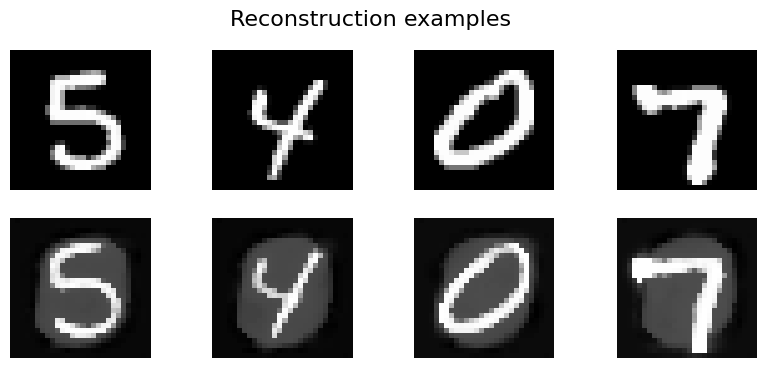

In [ ]:
vae_linear.plot_model_reconstruction(test_loader, reshape_linear_tensor)

## beta-VAE

In [19]:
beta_cnn_config = {
    "model_config": {
        "hidden_dims": [1, 2, 4, 8, 16], # Channels of hidden layers
        "z_dim": Z_DIM,
        "input_shape": [1, INPUT_DIM, INPUT_DIM],
        "relu_slope": 0.1,
        "batch_norm": True,
        "apply_sigmoid": False,
    },
    "hyperparameters": {
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "learning_rate": 0.0001,
        "loss_function": VAELossFunction,
        "beta": 20
    }
}
config_object = CNNVAEConfig(**beta_cnn_config)
beta_vae_cnn = Model(config_object, neptune_run=None)

In [20]:
beta_vae_cnn.train(train_loader, test_loader)

Epoch: 5, validation loss: 0.6258
Epoch: 10, validation loss: 0.5345
Epoch: 15, validation loss: 0.4636
Epoch: 20, validation loss: 0.4139
Best validation loss: 0.4139 in epoch: 20


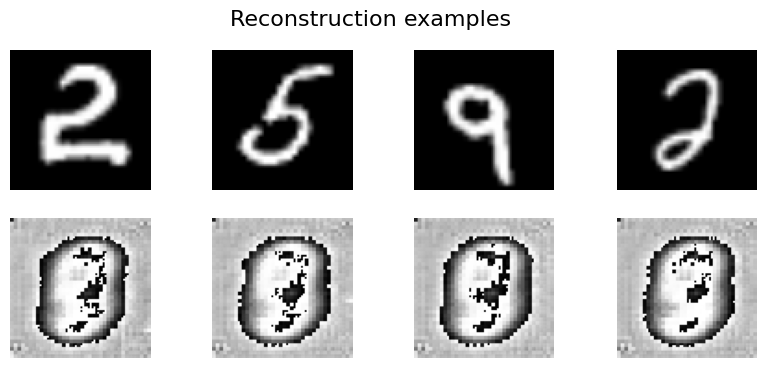

In [22]:
fig = beta_vae_cnn.plot_model_reconstruction(test_loader, lambda x : torch.squeeze(x))